In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D
from tensorflow.keras.models import Model

170508288/170498071 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 13, 13, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 13, 13, 64)   0           batch_normalization[0][0]        
___________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


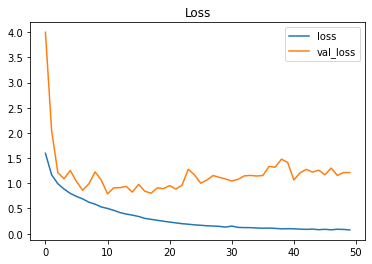

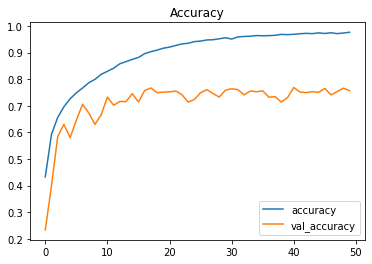

In [ ]:
class ResNet:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.shape = x_train[0].shape # for Input (32, 32, 3)
        self.num_class = len(np.unique(y_train)) # num of classes for outputs
        self.x_train = x_train/255
        self.x_test = x_test/255
        self.y_train = y_train.flatten()
        self.y_test = y_test.flatten()

    def inputLayer(self):
        return Input(shape=self.shape)

    def identityBlock(self, x, filtersize):
        # key point of resnet is shortcut
        
        # identity resnet 
        # shortcut: inpput
        # regular: weight 1 - relu - weight 2 - relu - weight 3  - add[f(x) + x] - relu

        # for concatenation
        shortcut = x
        if x.shape[-1] != filtersize:
		        shortcut = Conv2D(filtersize, (1,1), strides=(1, 1), padding='same', activation='relu')(x)

        # weight layer 1
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='same')(x) 
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 2
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='same')(x) 
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 3
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='same')(x) 
        x = BatchNormalization()(x)

        # f(x) + x
        x = Add()([x, shortcut])

        # relu
        x = Activation('relu')(x)

        return x

    def convBlock(self, x, filtersize):
        # key point of resnet is shortcut
       
        # convBlock:
        # shortcut: weight 1
        # regular: weight 1 - relu - weight 2 - relu - weight 3  - add[f(x) + x] - relu

        # for concatenation
        shortcut = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='valid')(x) # 'same' keeps the input x (30, 30, features) ->  (30, 30, features)
        shortcut = BatchNormalization()(shortcut) # this values are for adding 

        # weight layer 1
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='same')(x) 
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 2
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='same')(x) 
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 3
        x = Conv2D(filtersize, (3, 3), strides=(1, 1), padding='valid')(x) 
        x = BatchNormalization()(x)

        # f(x) + x
        x = Add()([x, shortcut])

        # relu
        x = Activation('relu')(x)

        return x

    def convBlockBottleNeck(self, x, filtersize): # this needs if we want to create more than 50 layers
       
        # for concatenation
        shortcut = Conv2D(filtersize, (1, 1), padding='valid')(x) # assume input x = (30, 30, features), then out put is (3--1+1 = 30, 3--1+1 = 30, features)
        shortcut = BatchNormalization()(x) # this values are for adding 

        filter, bottleneckFilter = filtersize

        # weight layer 1 (keep the input sizes, valid with (1x1) can keep the values)
        x = Conv2D(filter, (1, 1), padding='valid')(x)  # assume input x = (30, 30, features), then out put is (3--1+1 = 30, 3--1+1 = 30, features)
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 2
        x = Conv2D(filter, (3, 3), padding='same')(x) # 'same' keeps the input x (30, 30, features) ->  (30, 30, features)
        x = BatchNormalization()(x)

        # relu
        x = Activation('relu')(x)

        # weight layer 3  (keep the input sizes, valid with (1x1) can keep the values)
        x = Conv2D(bottleneckFilter, (1, 1), padding='valid')(x)  # keep the values
        x = BatchNormalization()(x)

        # f(x) + x
        x = Add()([x, shortcut])

        # relu
        x = Activation('relu')(x)

        return x

    def fullConnection(self, i, x):
        x = MaxPool2D()(x)
        x = Flatten()(x)
        x = Dropout(0.3)(x)  # drop out 20% of nodes randomly for regularization
        x = Dense(1024, activation='relu')(x)  # first Dense layer
        x = Dropout(0.3)(x)  # drop out 20% of nodes randomly for regularization
        x = Dense(self.num_class, activation='softmax')(x)  # output layer: set(y_train) collection of unique elements

        model = Model(i, x)  # model created here

        print(model.summary())  # check the model

        model, history = self.training(model)

        return model, history

    def training(self, model):

        model.compile(optimizer='adam',
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Model weights are saved at the end of every epoch, if it's the best seen
        checkpoint_filepath = '/temp/ResNet_tf2_Cifer10/checkpoint'

        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

        r = model.fit(self.x_train, self.y_train,
                      validation_data=(self.x_test, self.y_test),
                      epochs=50, batch_size = 50,
                      callbacks=[model_checkpoint_callback])
        # batch_size = 100 needs 12gb Ram or more

        # model save
        model.save('Cifar10.h5')
        np.save('my_history.npy', r.history)

        return r, r.history

    def plot(self, r, history):
        # step 4 Evaluate the model
        plt.plot(history['loss'], label="loss")
        plt.plot(history['val_loss'], label="val_loss")
        plt.title("Loss")
        plt.legend()
        plt.show()

        # if we want to have better val_accuracy, we need to get regularization well
        # 1) change the hyper parameters values (128 in this case)
        # 2) use random search for regularization

        plt.plot(history['accuracy'], label="accuracy")
        plt.plot(history['val_accuracy'], label="val_accuracy")
        plt.title("Accuracy")
        plt.legend()
        plt.show()

if __name__ == '__main__':
    data = tf.keras.datasets.cifar10
    (x_train, y_train), ( x_test, y_test) = data.load_data()
    resnet = ResNet(x_train, y_train, x_test, y_test) # preparing the dataset for the networks

    # preapare for Resent
    # (Conv2D) 7x7, 64, stride 2 
    # BatchNormalization
    # (MaxPool) 3x3 maxpool stride 2
    inputLayer = resnet.inputLayer()
    # model = ZeroPadding2D((3,3))(inputLayer)
    model = Conv2D(64, (7, 7), padding='valid', strides=2)(inputLayer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPool2D((3, 3), strides=2)(model)

    # 18 layers 
    model = resnet.convBlock(model, 64)
    model = resnet.identityBlock(model, 64)
    model = resnet.identityBlock(model, 64)

    model = resnet.convBlock(model, 128)
    model = resnet.identityBlock(model, 128)
    model = resnet.identityBlock(model, 128)

    # 34 layers 
    # 3rd Identity block layer
    # model = resnet.convBlock(model, 64)

    # 50 layers (do not add the 18 or 34 layers)
    # for itr in range(3):
    #   model = resnet.convBlockBottleNeck(model, (64, 256))

    model, history = resnet.fullConnection(inputLayer, model)

    resnet.plot(model, history)